In [5]:
import os
from pathlib import Path
import pandas as pd

# For GCC_PHAT calc
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft

from itertools import combinations


In [6]:
"""
 Estimate time delay using GCC-PHAT 
 Copyright (c) 2017 Yihui Xiong

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

import numpy as np


def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [7]:
def load():
    test_dirs = [f for f in Path("Data").iterdir() if f.is_dir()]
    # print(test_dirs)
    
    test_0 = test_dirs[4]
    pressure_data = pd.read_csv(test_0 / "pressures.csv", index_col=0, header=0)
    display(pressure_data)
    
    positions = pd.read_csv(test_0 / "positions.csv", index_col=0, header=0)
    display(positions)
    
    # Frequency is always the same so we can hard-code it
    FREQUENCY_HZ = 48000
    # with open(test_0 / "frequency_hz.txt") as freq_file:
    delays = []
    for mic1_header, mic2_header in combinations(pressure_data, 2):
        # print(mic1_header, mic2_header)
        s1, s2 = pressure_data[mic1_header], pressure_data[mic2_header]
        delay, cc = gcc_phat(s1, s2, FREQUENCY_HZ)
        delays.append(delay)
        plt.plot(cc)
        break
        #  print(delays)
        # plt.plot(np.correlate(s1, s2, "full"))
        # break
    plt.plot(delays)

,mic_0_pressure_Pa,mic_1_pressure_Pa,mic_2_pressure_Pa,mic_3_pressure_Pa,mic_4_pressure_Pa,mic_5_pressure_Pa,mic_6_pressure_Pa
0,-0.004150,-0.013855,-0.005035,0.000153,-0.000977,-0.000366,-0.01413
1,-0.004181,-0.013885,-0.005066,0.000122,-0.000946,-0.000366,-0.01416
2,-0.004150,-0.013855,-0.005066,0.000122,-0.000977,-0.000366,-0.01413
3,-0.004150,-0.013855,-0.005066,0.000122,-0.000977,-0.000366,-0.01413
4,-0.004150,-0.013824,-0.005066,0.000122,-0.000946,-0.000366,-0.01413
...,...,...,...,...,...,...,...
479995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
479996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
479997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
479998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


,X_meters,Y_meters
0,0.000,0.000
1,-0.029,0.071
2,0.029,-0.071
3,0.058,-0.142
4,-0.188,-0.003
5,-0.217,0.068
6,-0.159,-0.074


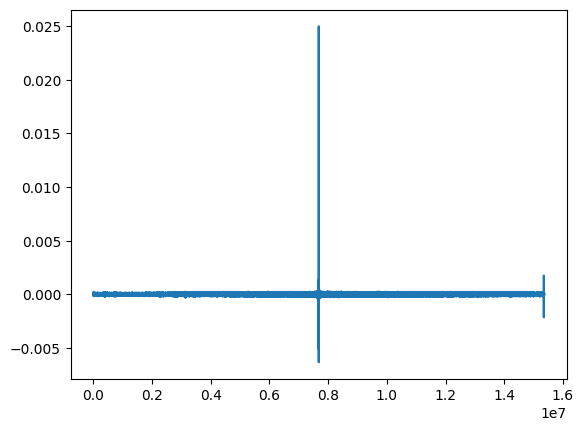

In [8]:
load()